# Starbucks Capstone Challenge

## Contest

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

#### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

***portfolio.json***
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

***profile.json***
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

***transcript.json***
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

#### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Results from the analysis
From the first raw data analysis that can be found below, we can make some key general statement: 
* the informal offers have an high view rate but are never closed
* BOGO offer have an higher view rate than discount one but a lower conversion rate
* Female have an higher view and conversion rate than men
* Subscription was flat in 2014 and 2016 and have an increse in Summer time for 2015 and (steeper) 2017
* During the first semester of 2018 this KPI is going bad

#### Next steps:
* Missing data on income were filled with overall mean value. Other methods to be tested (drop NA, filling with overall moda, filling with mean/moda by "nearest category, ...) 
* Age 118. It is clearly a mistype or the default value. In these records gender and income are not specified. Records could be dropped or forced to age 18.
* Futher analysis on macro data (distribution of order price, income, ...)
* ML analysis using different ML engine and different percentage of data for train/test/validate, using also random sampling

# Project developement

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns
from sklearn.metrics import fbeta_score, make_scorer

In [2]:
# read in the json files
portfolio = pd.read_json('./data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('./data/profile.json', orient='records', lines=True)
transcript = pd.read_json('./data/transcript.json', orient='records', lines=True)

### Exploratory Data Analysis and Cleansing

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
# One hot encode channels data 
available_channels = []

#Differientiate the channels column
for channel in portfolio['channels']:
    for t in channel:
        if t not in available_channels:
            available_channels.append(t)

for channel in available_channels:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)  

portfolio.drop('channels', axis = 1, inplace=True) 

# ??? sono già int64
#cols_to_update = ['difficulty', 'duration','reward']
#for col in cols_to_update:
#    portfolio[col] = portfolio[col].apply(lambda x: int(x))

portfolio    

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [5]:
profile.head(100)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [6]:
profile.shape

(17000, 5)

In [7]:
profile.groupby(['gender'])['gender'].count()

gender
F    6129
M    8484
O     212
Name: gender, dtype: int64

In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [9]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


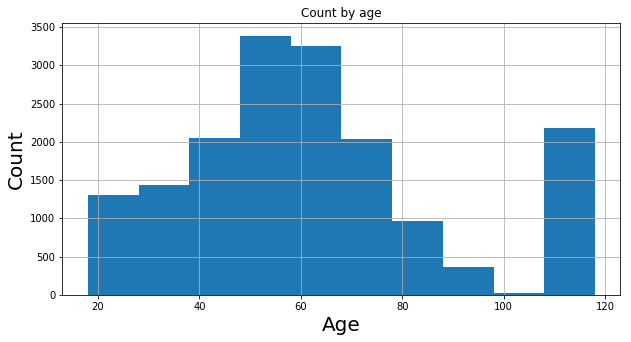

In [10]:
profile.age.hist(figsize = (10,5))
plt.ylabel('Count', fontsize = 20)
plt.xlabel('Age', fontsize = 20)
plt.title('Count by age');

for further analysis
for i in range(11):
        if i != 0:
            #calculate the decade the person lives in ...
            stage = i * 10
            profile[str(stage)+"'s"] = profile['age'].apply(lambda x:1 if((x-stage<10)and (x-stage>=0)) else 0)

In [11]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


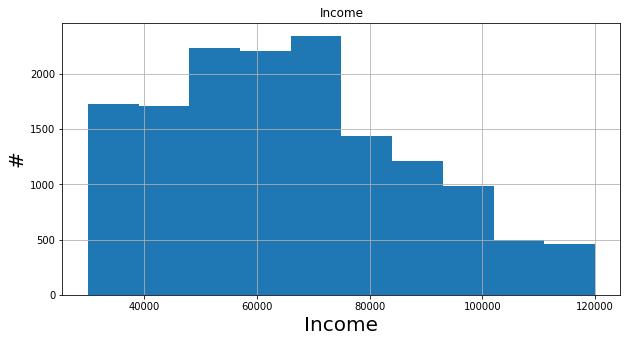

In [12]:
profile.income.hist(figsize = (10,5))
plt.ylabel('#', fontsize = 20)
plt.xlabel('Income', fontsize = 20)
plt.title('Income');

In [13]:
print(profile[profile['age']==118].count())
profile[['gender','income','age']][profile['age']==118].head()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64


,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


In [14]:
# lean and fill data
profile['gender'].fillna('Unknown', inplace = True)
profile['income'] = profile['income'].apply(lambda x: float(x))
profile['age'] = profile['age'].apply(lambda x: int(x))
mean_val = profile.income.mean() 
profile['income'].fillna(mean_val, inplace = True)

In [15]:
# other tuning on data
profile['member_year'] = profile.became_member_on.apply(lambda x: int(str(x)[:4]))
profile['member_month'] = profile.became_member_on.apply(lambda x: int(str(x)[4:6]))
profile['member_day'] = profile.became_member_on.apply(lambda x: int(str(x)[6:]))
profile['member_date'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
profile.drop('became_member_on', axis = 1, inplace = True)
profile.head()

,age,gender,id,income,member_year,member_month,member_day,member_date
0,118,Unknown,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017,2,12,2017-02-12
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,2017,7,15,2017-07-15
2,118,Unknown,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,2018,7,12,2018-07-12
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017,5,9,2017-05-09
4,118,Unknown,a03223e636434f42ac4c3df47e8bac43,65404.991568,2017,8,4,2017-08-04


In [16]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [17]:
transcript.shape

(306534, 4)

In [18]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [19]:
# almost useless ;-)
transcript.groupby(['event']).describe()

time                                                    \
                    count        mean         std  min    25%    50%    75%   
event                                                                         
offer completed   33579.0  401.052801  192.352614  0.0  240.0  432.0  564.0   
offer received    76277.0  332.579519  196.489548  0.0  168.0  408.0  504.0   
offer viewed      57725.0  354.290515  199.317684  0.0  180.0  408.0  516.0   
transaction      138953.0  381.584334  201.697230  0.0  210.0  402.0  552.0   

                        
                   max  
event                   
offer completed  714.0  
offer received   576.0  
offer viewed     714.0  
transaction      714.0

In [20]:
transcript['value_type'] = transcript['value'].apply(lambda x: list(x.keys())[0]) 
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0]) 
transcript['time'] = transcript['time'].apply(lambda x: int(x))
transcript.head()

,event,person,time,value,value_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer id
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,offer id
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,offer id
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,offer id
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,offer id


In [21]:
#transcript[transcript['value_type']=='amount']
transcript.groupby(['value_type'])['value_type'].count()

value_type
amount      138953
offer id    134002
offer_id     33579
Name: value_type, dtype: int64

#### Drill down

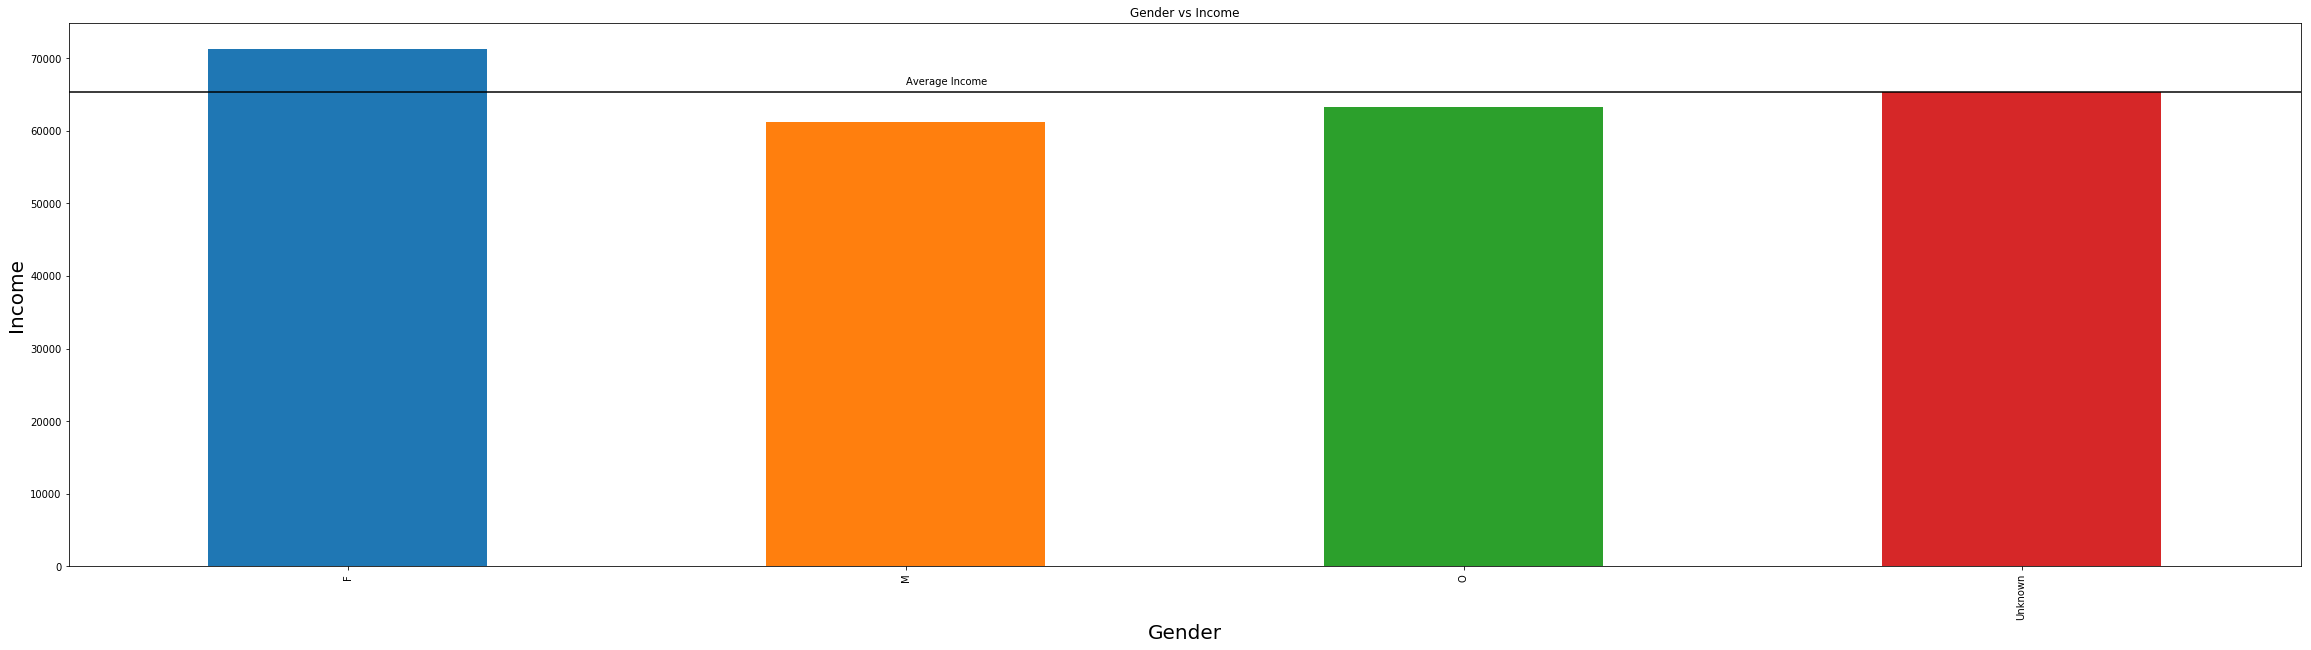

In [22]:
gender_income = profile.groupby('gender', as_index=False).agg({'income':'mean'})
gender_income.plot(kind = 'bar', x = 'gender', y = 'income', legend=False, figsize=(40,10))
plt.hlines(mean_val, -100 , 1000)
plt.ylabel('Income', fontsize = 20)
plt.xlabel('Gender', fontsize = 20)
plt.title('Gender vs Income')
plt.text(1, mean_val + 1000, 'Average Income');

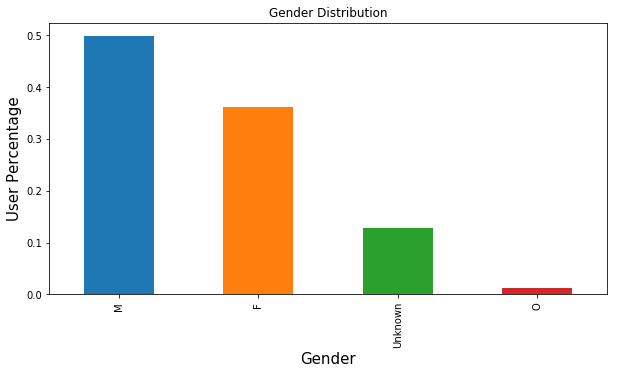

In [23]:
profile.gender.value_counts(normalize=True).plot('bar', figsize = (10,5))
plt.title('Gender Distribution')
plt.ylabel('User Percentage', fontsize = 15)
plt.xlabel('Gender', fontsize = 15);

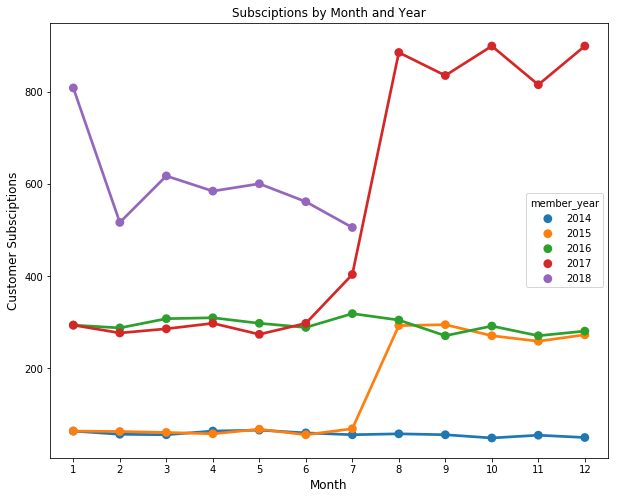

In [24]:
# variare con mese-anno
membership_subs = profile[profile['member_year'] >= 2014].groupby(['member_year','member_month'], as_index=False).agg({'id':'count'})
plt.figure(figsize=(10,8))
sns.pointplot(x="member_month", y="id", hue="member_year", data = membership_subs)
plt.ylabel('Customer Subsciptions', fontsize = 12)
plt.xlabel('Month', fontsize = 12)
plt.title('Subsciptions by Month and Year');

In [25]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [26]:
transcriptL = transcript.merge(portfolio,how='left',left_on='value', right_on='id')
transcriptL.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

In [27]:
transcriptL = transcriptL.merge(profile,how='left',left_on='person', right_on='id')

In [28]:
transcriptL.groupby(['gender', 'event'])['offer_type'].count() #'offer_type',

gender   event          
F        offer completed    15477
         offer received     27456
         offer viewed       20786
         transaction            0
M        offer completed    16466
         offer received     38129
         offer viewed       28301
         transaction            0
O        offer completed      501
         offer received       916
         offer viewed         773
         transaction            0
Unknown  offer completed     1135
         offer received      9776
         offer viewed        7865
         transaction            0
Name: offer_type, dtype: int64

In [29]:
transcriptL.groupby(['age', 'event'])['offer_type'].count()

age  event          
18   offer completed     129
     offer received      324
     offer viewed        215
     transaction           0
19   offer completed     191
     offer received      597
     offer viewed        437
     transaction           0
20   offer completed     216
     offer received      587
     offer viewed        410
     transaction           0
21   offer completed     241
     offer received      617
     offer viewed        434
     transaction           0
22   offer completed     211
     offer received      589
     offer viewed        399
     transaction           0
23   offer completed     226
     offer received      580
     offer viewed        392
     transaction           0
24   offer completed     252
     offer received      644
     offer viewed        434
     transaction           0
25   offer completed     238
     offer received      605
                        ... 
95   offer viewed         70
     transaction           0
96   offer completed  

#### Further analysis to come
By person, by campaign, ...

In [30]:
transcriptL[transcriptL['value'] == 'fafdcd668e3743c1bb461111dcafc2a4'].groupby(['gender', 'event'])['event'].count()

gender   event          
F        offer completed    2216
         offer received     2696
         offer viewed       2608
M        offer completed    2721
         offer received     3868
         offer viewed       3711
O        offer completed      66
         offer received       88
         offer viewed         88
Unknown  offer completed     314
         offer received      945
         offer viewed        920
Name: event, dtype: int64

In [31]:
transcriptL[transcriptL['person'] == '94de646f7b6041228ca7dec82adb97d2'].groupby(['gender', 'event', 'offer_type'])['event'].count()

gender  event            offer_type
M       offer completed  bogo          3
                         discount      2
        offer received   bogo          4
                         discount      2
        offer viewed     bogo          4
                         discount      1
Name: event, dtype: int64

In [32]:
transcriptR = transcript.merge(portfolio,how='right',left_on='value', right_on='id')
transcriptR = transcriptL.merge(profile,how='left',left_on='person', right_on='id')
transcriptR.groupby(['offer_type','value'])['value'].count()

offer_type     value                           
bogo           4d5c57ea9a6940dd891ad53e9dbe8da0    18222
               9b98b8c7a33c4b65b9aebfe6a799e6d9    16202
               ae264e3637204a6fb9bb56bc8210ddfd    18062
               f19421c1d4aa40978ebb69ca19b0e20d    19131
discount       0b1e1539f2cc45b7b9fa7c272da2e1d7    13751
               2298d6c36e964ae4a3e7e9706d1fb8c2    20139
               2906b810c7d4411798c6938adc9daaa5    15767
               fafdcd668e3743c1bb461111dcafc2a4    20241
informational  3f207df678b143eea3cee63160fa8bed    11761
               5a8bc65990b245e5a138643cd4eb9837    14305
Name: value, dtype: int64